# Correcting for Imbalanced Training Data

In the results of the previous notebook you can see many instances where a 'W' image was predicted to be some other letter, i.e. poor recall. There may yet be some remaining ways to improve the recall of the model's predictions. One difference we should note is that in our training data a W is about as likely as any other character. Whereas in our target data, the W is by far the most likely character. In these test pages the W is in 142/150 images, for instance. That is a big difference that the predictive model does not take into account.

In order to make the model's predictions closer to the reality of the target data, we must correct the imbalance between training and target data. We followed a [Keras guide](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) to calculate an initial bias setting for the predictive model.

Along the way we are also going to simplify the output of our predictive model. Thus far we have been predicting which letter of the alphabet is present in the image, as is the case in any tutorial on recognizing handwritten characters. Instead, we will change our output to a single ratio, the confidence the model has that the image is a W. This allows us to focus on the precision and recall of that since determination and better matches our use case.

The first thing we have to do is alter our training and test data such that instead of 26 different classification labels, we only have 1 for a W and 0 for not a W. We can do this at the same time as we are transposing the character images to a readable orientation. Look for `label == 23` in the code below to find this adjustment.

In [1]:
# Load the segmentation code that we developed in that notebook
with open("segmentation.py") as f:
    code = f.read()
exec(code)

import tensorflow_datasets as tfds
import tensorflow as tf
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train_readable = ds_train.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), tf.cast([(label == 23)], tf.int64)),
  num_parallel_calls=tf.data.AUTOTUNE,
  deterministic=True)

def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label
ds_train_readable_float = ds_train_readable.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

def set_shapes(image, label):
  image.set_shape([28, 28, 1])
  label.set_shape([1])
  return image, label
ds_train_final = ds_train_readable_float.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)

# Some additional dataset setup steps
ds_train_final = ds_train_final.cache()
ds_train_final = ds_train_final.batch(400)  # This changes the shape of the data, so call it after all mapped functions..
ds_train_final = ds_train_final.prefetch(tf.data.AUTOTUNE)
print("final element_spec", ds_train_final.element_spec)

# Then we need to apply the same functions and settings to the test dataset
ds_test_readable = ds_test.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), tf.cast([(label == 23)], tf.int64)),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

ds_test_readable_float = ds_test_readable.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_final = ds_test_readable_float.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_final = ds_test_final.batch(400)
ds_test_final = ds_test_final.cache()
ds_test_final = ds_test_final.prefetch(tf.data.AUTOTUNE)

2025-01-16 12:00:55.450194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 12:00:55.450427: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 12:00:55.452407: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 12:00:55.477567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 12:00:55.991433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

final element_spec (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))


2025-01-16 12:00:56.457319: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-01-16 12:00:56.457338: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: graeber
2025-01-16 12:00:56.457342: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: graeber
2025-01-16 12:00:56.457427: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 565.77.0
2025-01-16 12:00:56.457437: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 560.35.3
2025-01-16 12:00:56.457439: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 560.35.3 does not match DSO version 565.77.0 -- cannot find working devices in this configuration


Now that the training labels are saying W or not W, we can do some math to figure out the initial bias of the training data.

In [2]:
import numpy as np
labels, counts = np.unique(np.fromiter(ds_train_readable.map(lambda x, y: y), np.int32), return_counts=True)
pos = counts[1]
neg = counts[0]
total = neg + pos
print(labels)
print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100*pos/total:.2f}% of total)')

initial_bias = np.log([pos/neg])
print(f'Initial bias: {initial_bias}')

2025-01-16 12:01:01.988707: E tensorflow/core/util/util.cc:131] oneDNN supports DT_UINT8 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


[0 1]
Examples:
    Total: 88800
    Positive: 3423 (3.85% of total)
Initial bias: [-3.21655938]


2025-01-16 12:01:04.314596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
from tensorflow import keras

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_conv_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = tf.keras.models.Sequential([
        keras.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=metrics)

    return model

conv_model = make_conv_model(output_bias=initial_bias)
conv_model.fit(
    ds_train_final,
    epochs=15,
    validation_data=ds_test_final,
)

Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - Brier score: 0.0199 - accuracy: 0.9759 - auc: 0.9426 - cross entropy: 0.0788 - fn: 781.1031 - fp: 143.6188 - loss: 0.0788 - prc: 0.6560 - precision: 0.7772 - recall: 0.4263 - tn: 42939.7500 - tp: 933.7354 - val_Brier score: 8.4940e-04 - val_accuracy: 0.9994 - val_auc: 0.0000e+00 - val_cross entropy: 0.0059 - val_fn: 0.0000e+00 - val_fp: 9.0000 - val_loss: 0.0059 - val_prc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 14791.0000 - val_tp: 0.0000e+00
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - Brier score: 0.0066 - accuracy: 0.9916 - auc: 0.9944 - cross entropy: 0.0251 - fn: 248.3946 - fp: 115.6951 - loss: 0.0251 - prc: 0.9482 - precision: 0.9213 - recall: 0.8489 - tn: 42967.6719 - tp: 1466.4440 - val_Brier score: 4.3820e-04 - val_accuracy: 0.9996 - val_auc: 0.0000e+00 - val_cross entropy: 0.0030 - val_fn: 0.0000e+00 - val_fp: 6.0000 - val_loss: 0.0030 - val_prc: 0.0000e+00 - val_precision: 0.0

Finally, we need to set up our run method again with adjustments for the new model output of a single floating point value (W confidence).

In [4]:
import keras
conv_model = keras.saving.load_model("conv_model_balanced.keras")

pages/43290879-California-101393-0002.jpeg


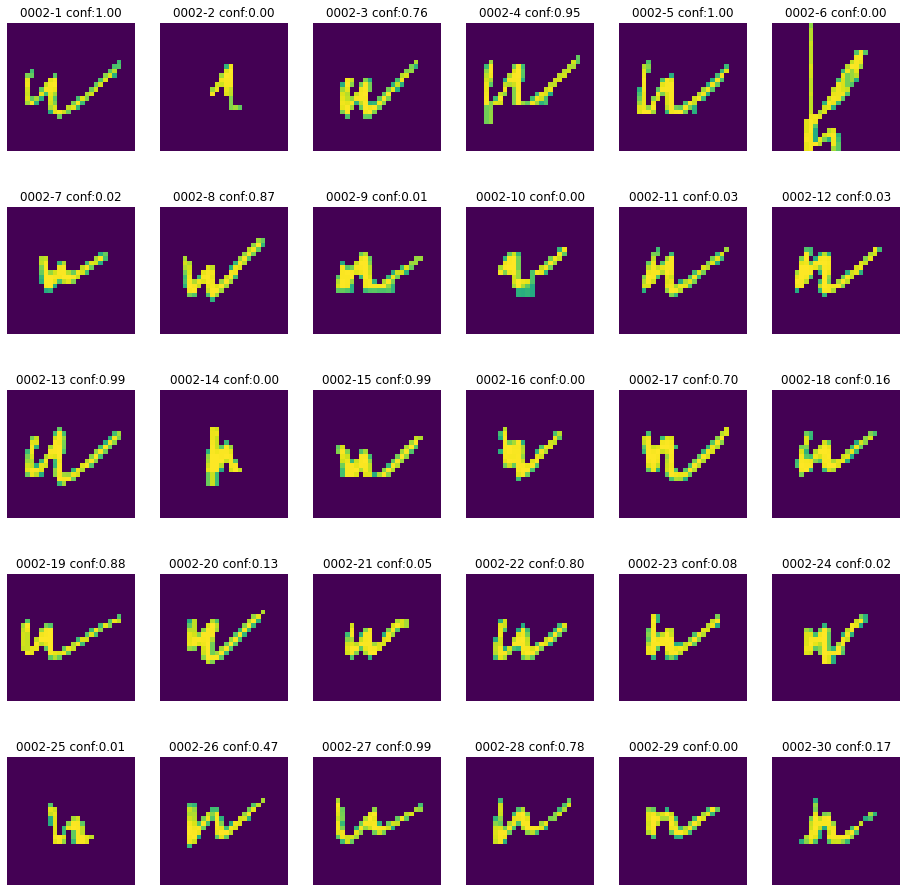

pages/43290879-California-101393-0003.jpeg


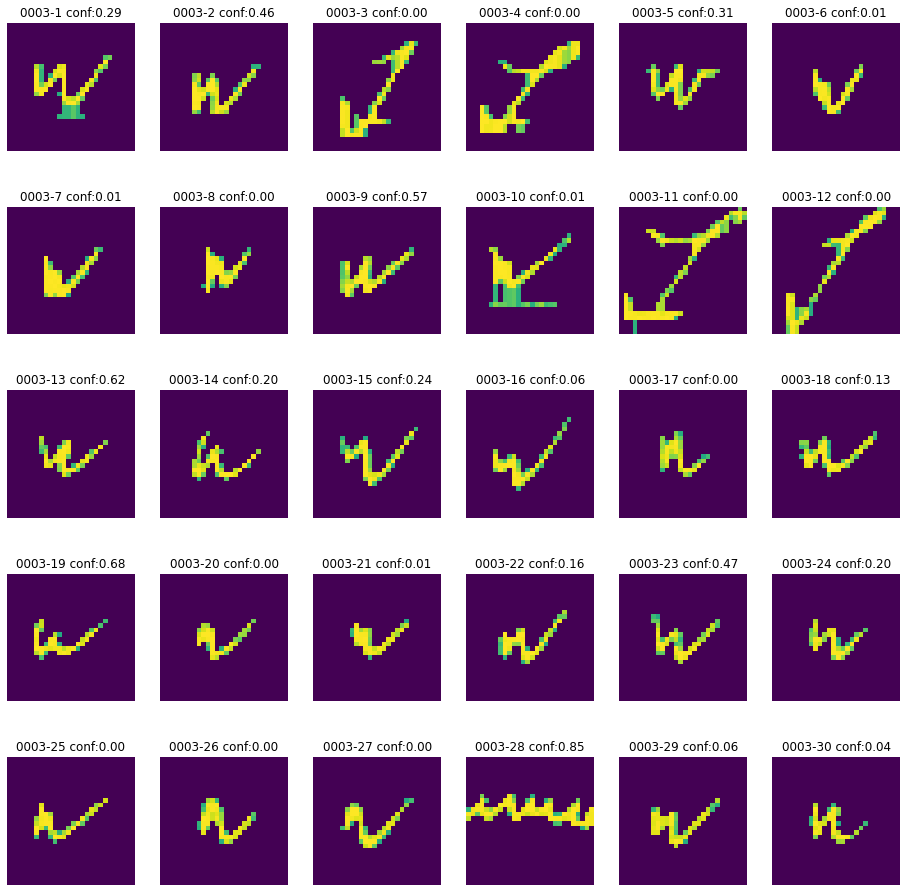

pages/43290879-California-101393-0004.jpeg


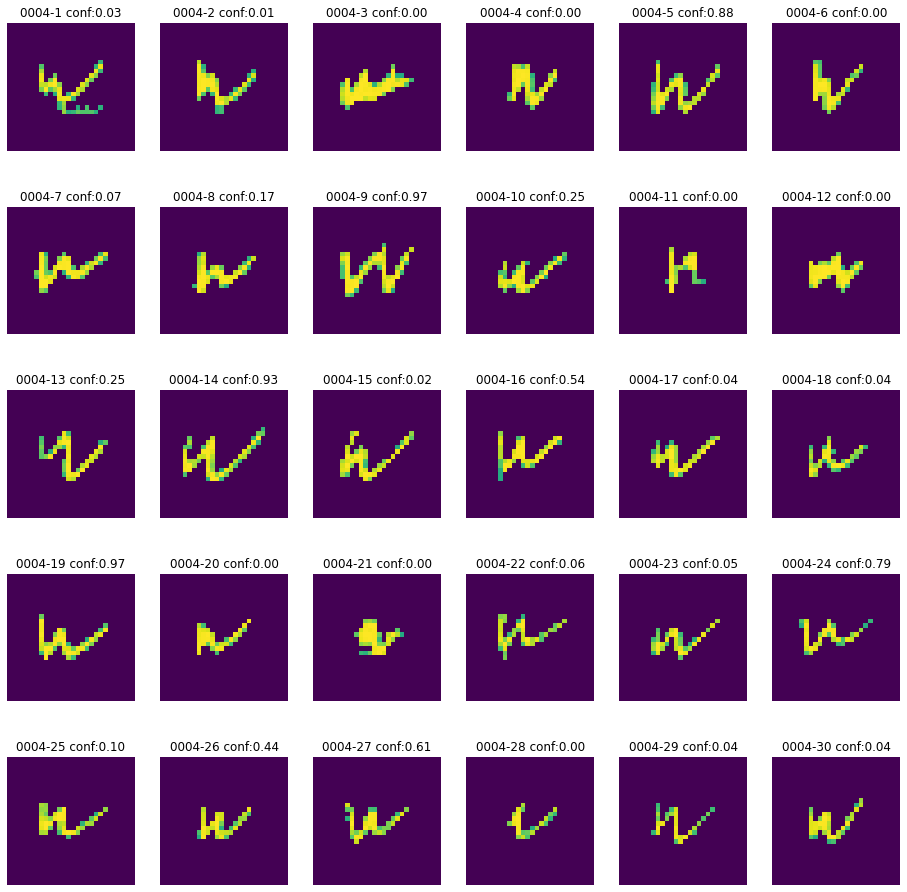

pages/43290879-California-101393-0005.jpeg


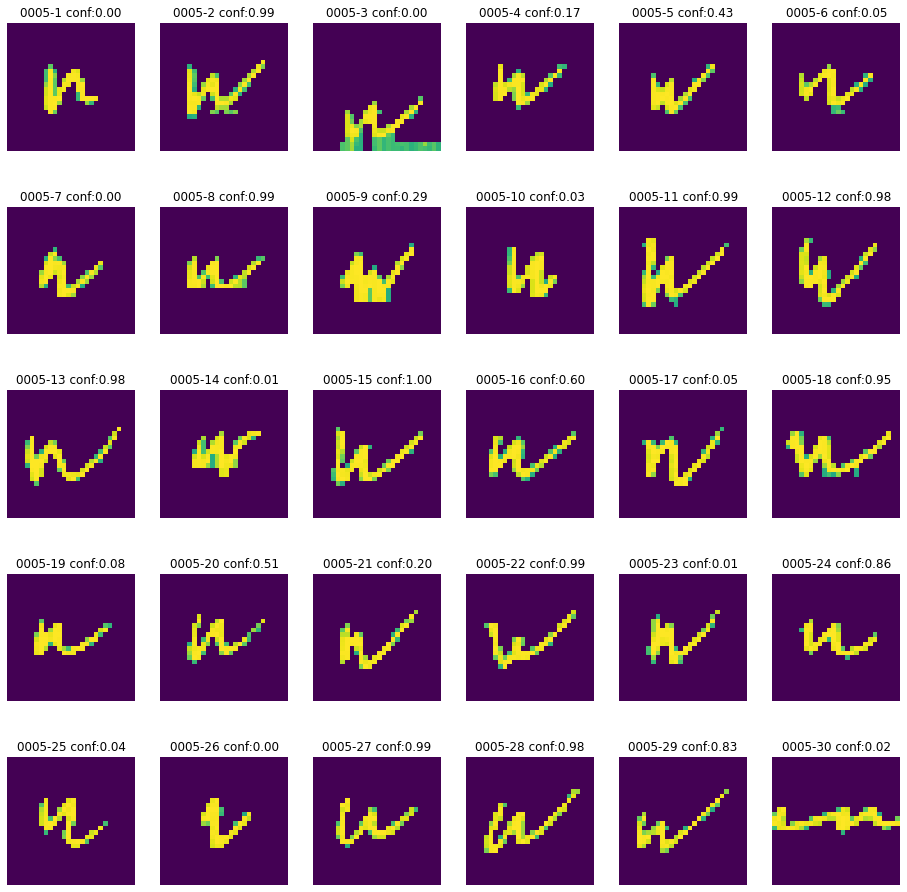

pages/43290879-California-101393-0006.jpeg


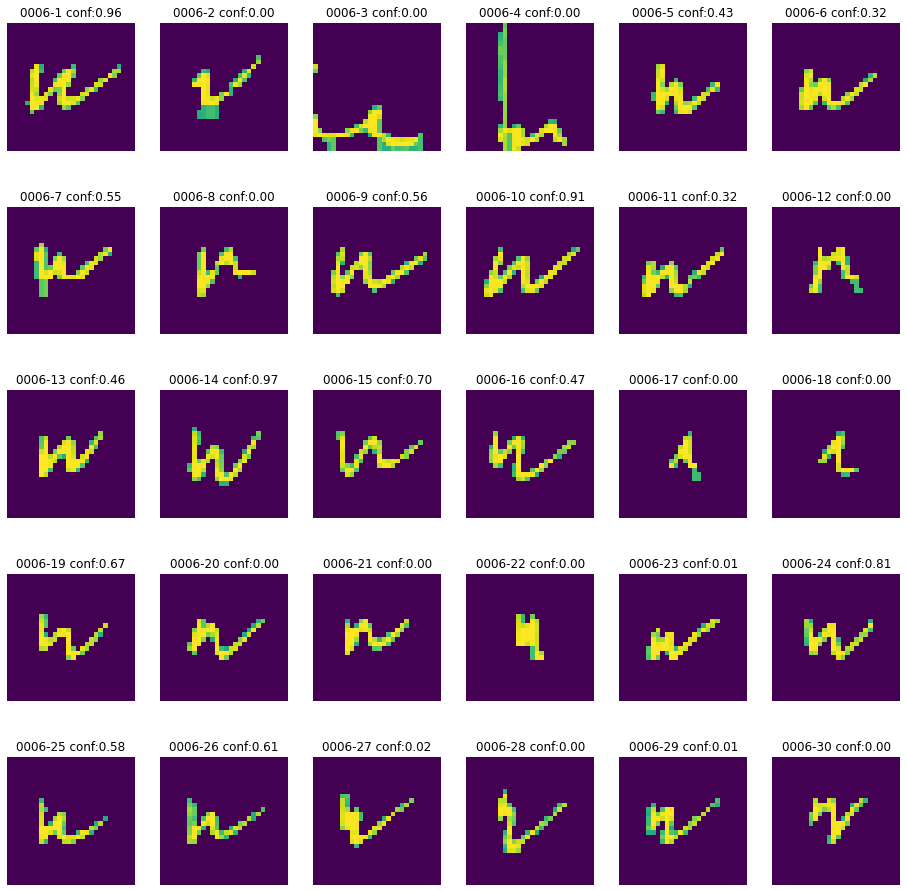

pages/43290879-California-101393-0007.jpeg


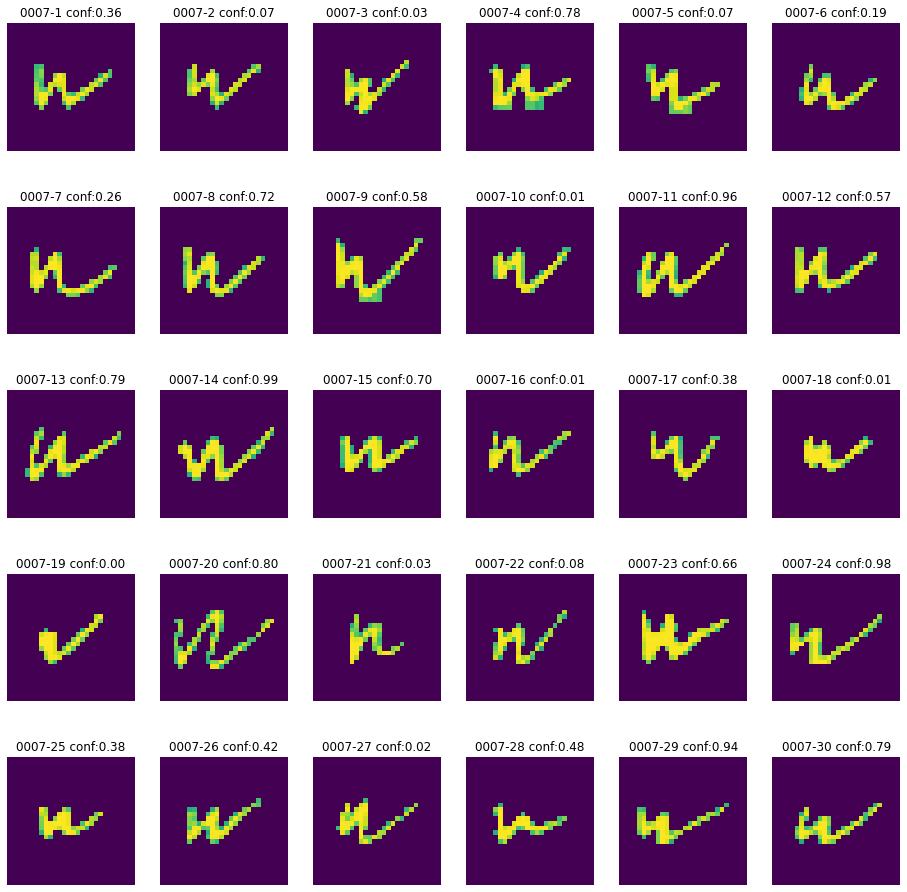

precision 0.9833333333333333 recall 0.4154929577464789


In [6]:
import glob
import re
import cv2     
import matplotlib.pyplot as plt

not_Ws = {
    2: [6],
    3: [3, 4, 11, 12, 28],
    4: [],
    5: [],
    6: [3,4],
    7: []
}

Ws = 30*5-8

def run(path, page_range=(2, 16), model=None, threshold=0.5, debug=False):
    cnt_detected = 0
    cnt_true_positive = 0
    cnt_false_positive = 0
    cnt_true_negative = 0
    cnt_false_negative = 0
    
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d+).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        plt.figure(figsize=(16, 16))
        print(f)
        image = cv2.imread(f)
        (adjusted_img, v_lines, h_lines) = extract(image, f, debug=debug)
        grayimage = cv2.cvtColor(adjusted_img,cv2.COLOR_BGR2GRAY)
        grayimage = 255 - grayimage
        demo_h_offset = v_lines[11]  # the demographic column starts the the 12th vertical line
        demo_width = v_lines[12] - demo_h_offset  # width calculation
        # Open CV rectangles calculation for each demographic cell
        demographic_cells = \
          [ (demo_h_offset, h_lines[i], demo_width, int(h_lines[i+1]-h_lines[i])) for i in range(3, len(h_lines)-1)]
        for i in range(3, len(h_lines)-1):
            num = i-2
            ax = plt.subplot(5, 6, i - 2)
            plt.axis('off')
            cell_img = grayimage[h_lines[i]+5:h_lines[i+1]+5, v_lines[11]:v_lines[12]]
            prepared_cell_image = crop_cell(cell_img)
            tensor, noop = normalize_img(prepared_cell_image, 0)
            result = model.predict(np.expand_dims(tensor, 0), verbose=0)[0][0]
            if result >= threshold:
                cnt_detected += 1
                if num in not_Ws[int(pagestr)]:
                    cnt_false_positive += 1
                else:
                    cnt_true_positive += 1
            else:
                if num in not_Ws[int(pagestr)]:
                    cnt_true_negative += 1
                else:
                    cnt_false_negative += 1
            plt.imshow(prepared_cell_image)
            plt.title(f'{pagestr}-{num} conf:{result:.2f}')
        plt.show()
    print(f'precision {cnt_true_positive/cnt_detected} recall {cnt_true_positive/Ws}')

run('pages', page_range=(2,8), model=conv_model)

This is certainly an improvement over the previous results. We have corrected for the frequency that Ws appear in normal alphabets. However, the model remain unaware of just how likely a W is in our target data. You may have noticed that I set up a confidence threshold of 50% or 0.5 for interpreting the model's prediction. That threshold is also made a parameter of the run function, so you can plug in whatever threshold works best. We can try lowering the threshold to increase recall, so long as it does not reduce precision unacceptably. In our testing we went as far as a 4% confidence threshold and acheived 77% recall with a precision of 99%.

pages/43290879-California-101393-0002.jpeg


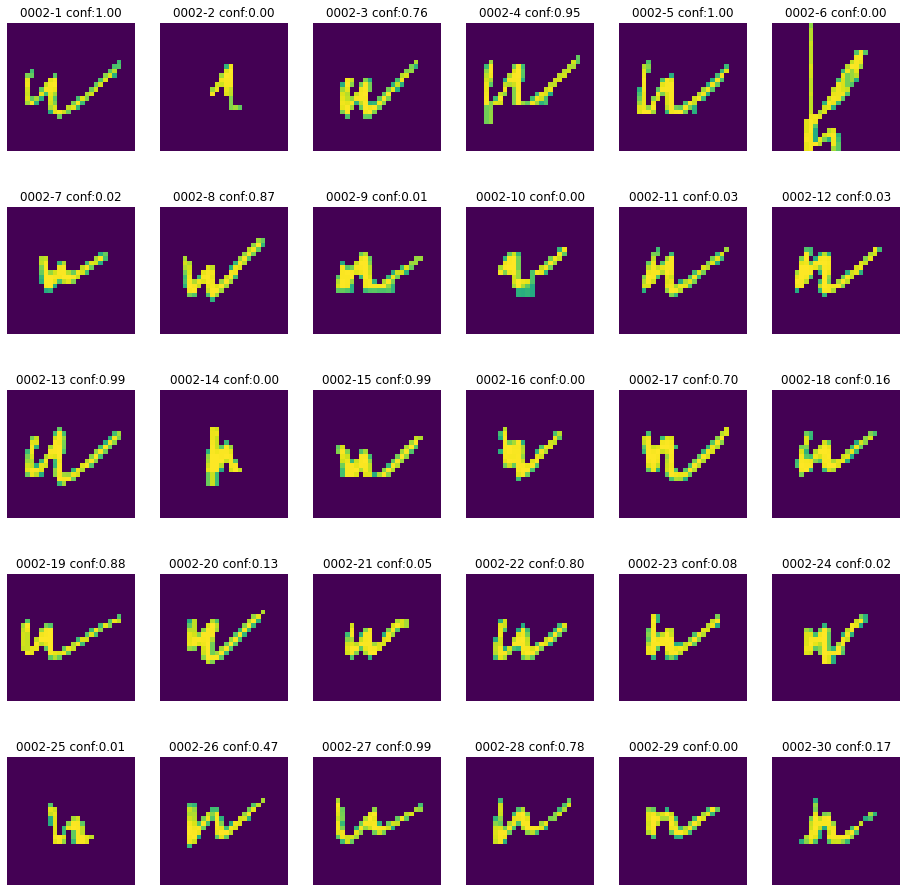

pages/43290879-California-101393-0003.jpeg


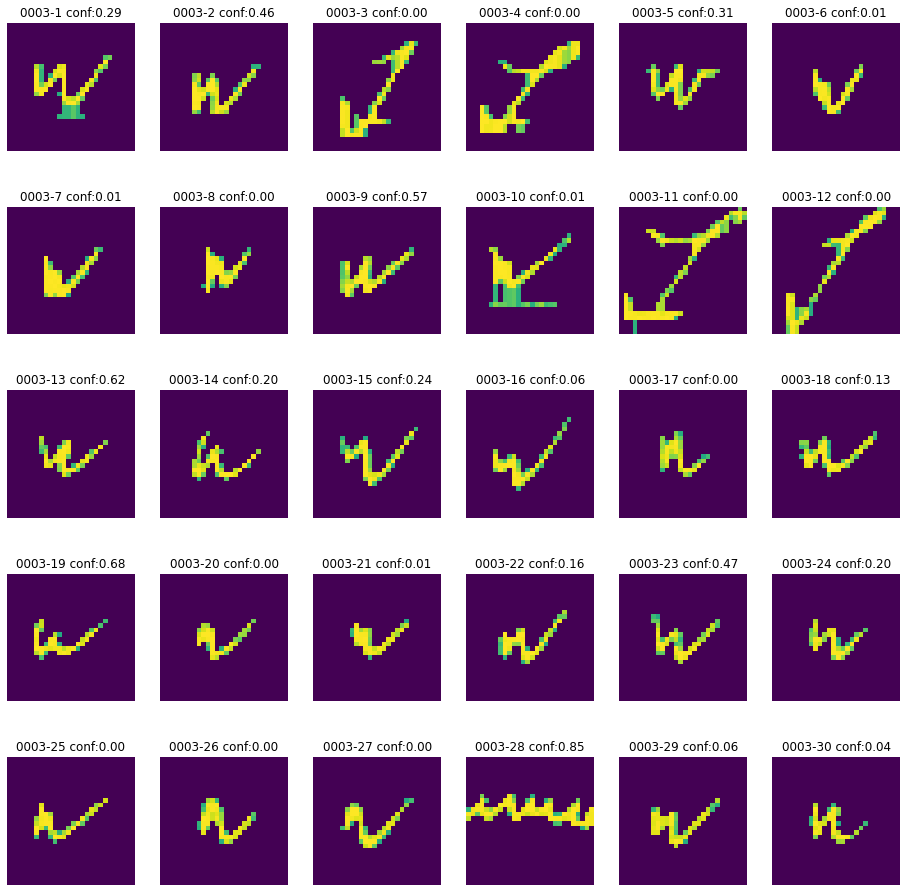

pages/43290879-California-101393-0004.jpeg


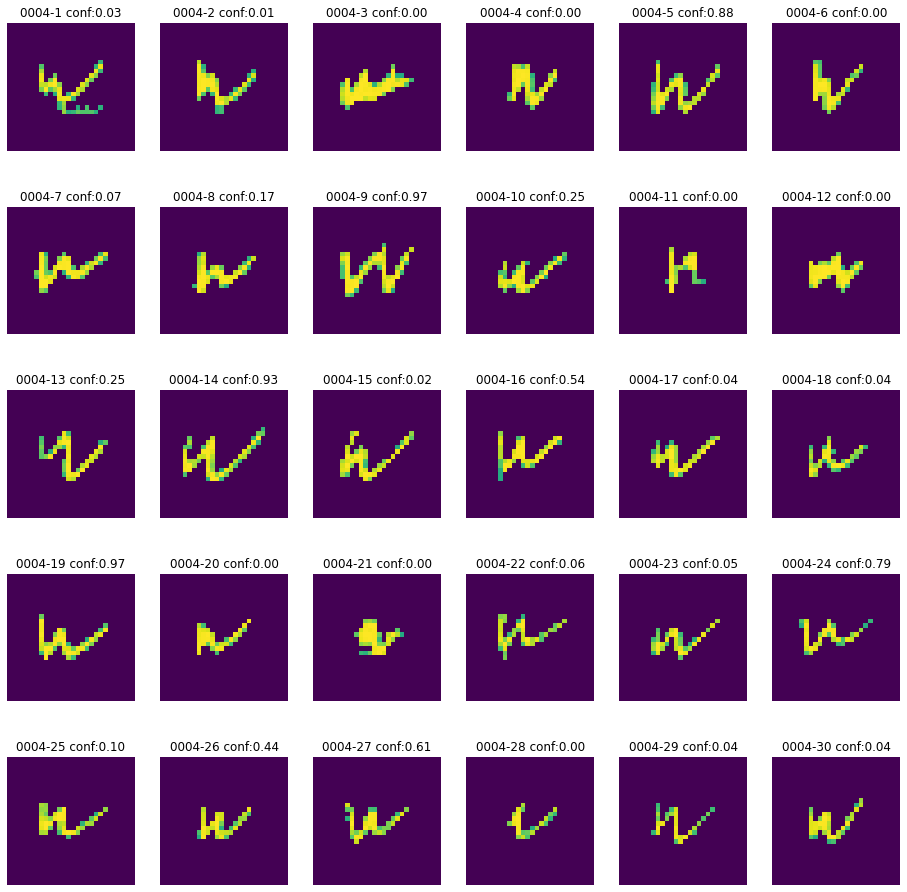

pages/43290879-California-101393-0005.jpeg


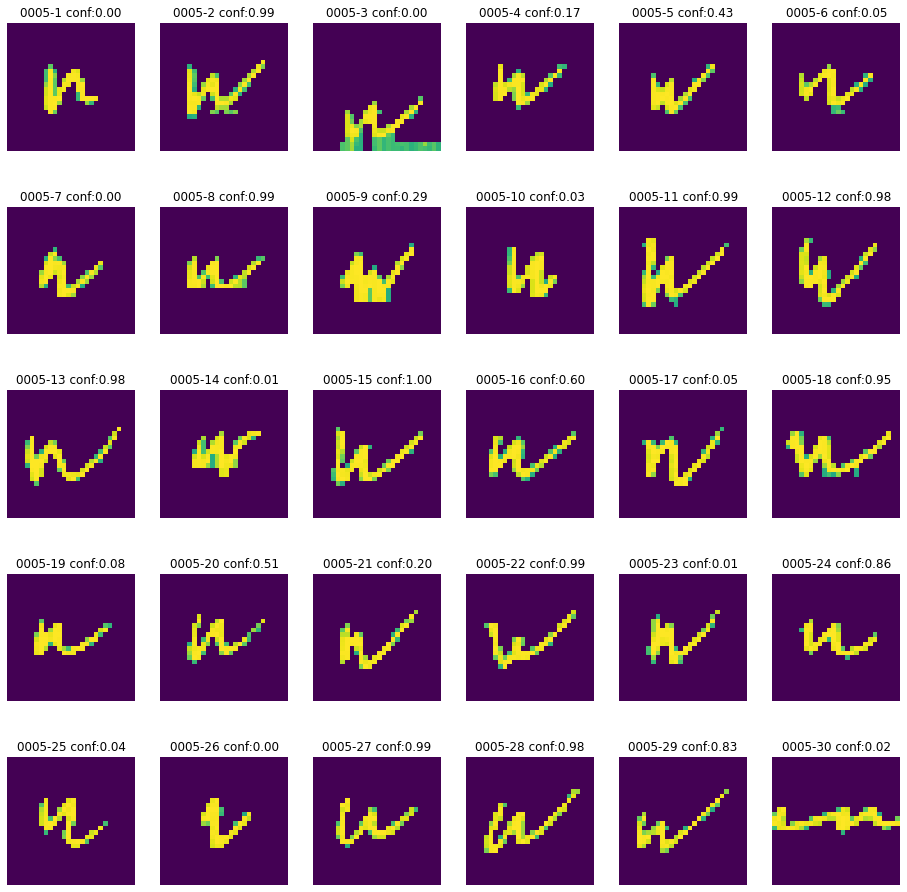

pages/43290879-California-101393-0006.jpeg


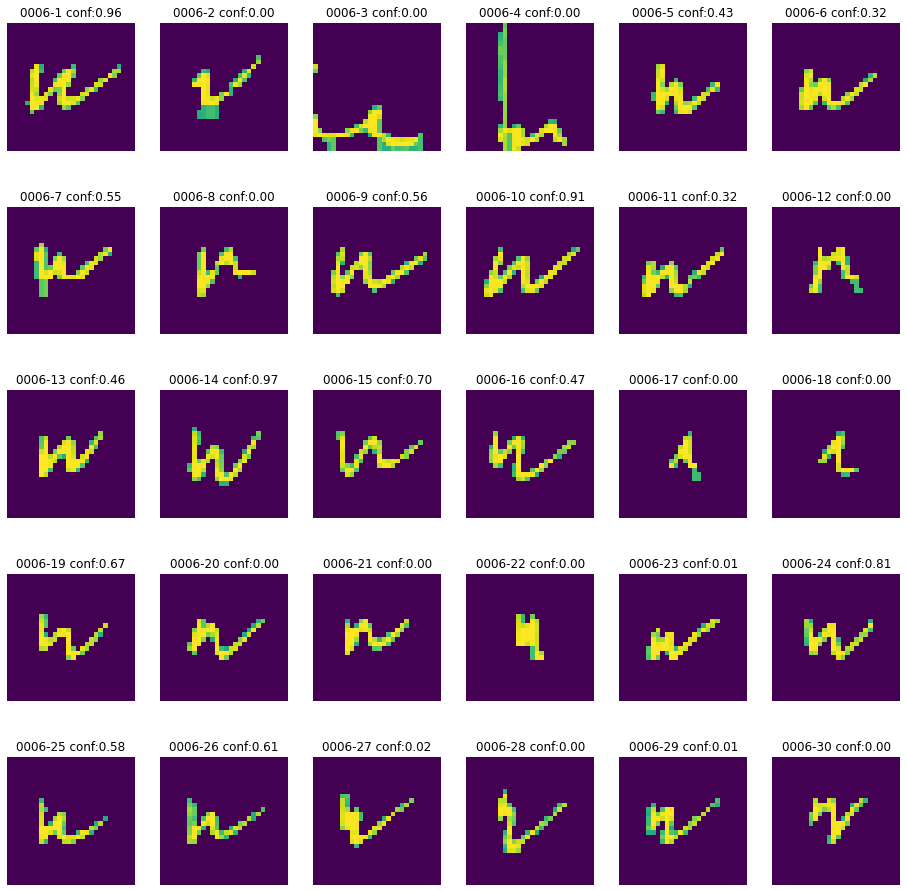

pages/43290879-California-101393-0007.jpeg


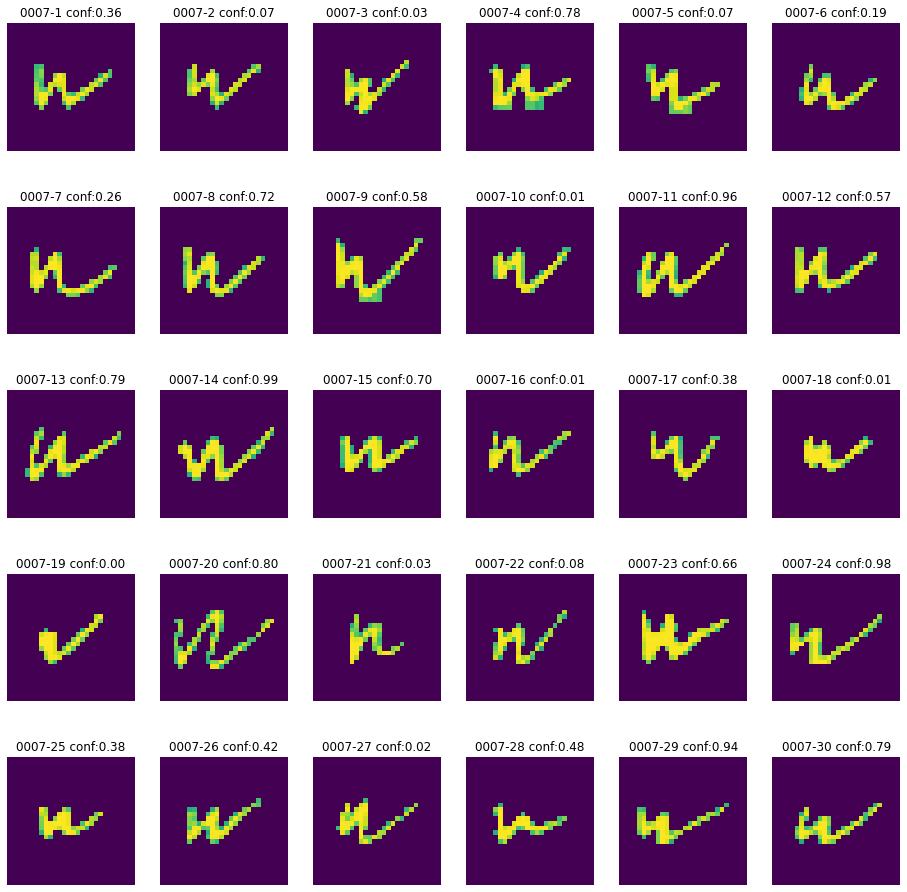

precision 0.9908256880733946 recall 0.7605633802816901


In [7]:
run('pages', page_range=(2,8), model=conv_model, threshold=0.04)

In [30]:
conv_model.save("conv_model_balanced.keras", overwrite=True)